In [1]:
import numpy as np
import pickle
from scipy.stats import pearsonr
from scipy.stats import skew
import sys
from sklearn.metrics.pairwise import pairwise_distances
%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

sys.path.append('../')
import scripts.outliers as outliers
import scripts.utils_spatial as utils_spatial

In [5]:
X_list, Y, Yaudio = pickle.load(open('../data/lda_data_melodia_8.pickle','rb'))
#ddf = outliers.load_metadata(Yaudio, metadata_file='../data/metadata.csv')
#w, data_countries = utils_spatial.get_neighbors_for_countries_in_dataset(Y)
#w_dict = utils_spatial.from_weights_to_dict(w, data_countries)
X = np.concatenate(X_list, axis=1)

# global outliers
#df_global, threshold, MD = outliers.get_outliers_df(X, Y, chi2thr=0.999)

In [3]:
X.shape

(8200, 380)

In [4]:
D = pairwise_distances(X, metric='mahalanobis')

In [5]:
D.shape

(8200, 8200)

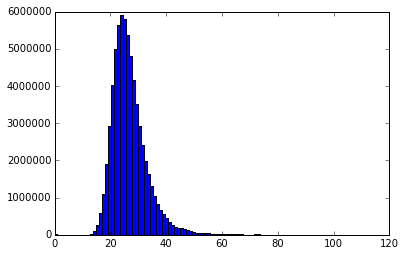

In [6]:
plt.hist(D.ravel(), bins=100);

In [7]:
def n_occurrence_from_D(D, k=10, n_items=None):
    if n_items is None:
        n_items = len(D)
    sort_idx = np.argsort(D, axis=1)
    D_k = sort_idx[:, 1:(k+1)]  # nearest neighbour is the item itself
    N_k = np.bincount(D_k.astype(int).ravel(), minlength=n_items)
    return N_k

8.18316065981


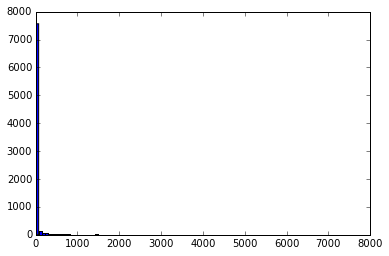

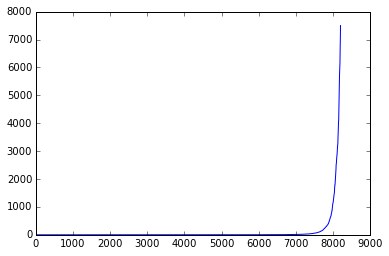

In [8]:
N_k = n_occurrence_from_D(D, k=100)
print skew(N_k)
plt.figure()
plt.hist(N_k, bins=100);
plt.figure()
plt.plot(np.sort(N_k))

In [16]:
sort_idx = np.argsort(D, axis=1)
k = 100
D_k = sort_idx[:, 1:(k+1)]

In [17]:
D_k

array([[4650, 2942, 3520, ..., 3488, 2864, 6361],
       [1933, 6143, 6757, ..., 2346, 3441, 6857],
       [3170, 2549, 4860, ..., 2260, 2978, 7433],
       ..., 
       [6016, 2243, 1616, ..., 3486, 3441, 4554],
       [7027, 4860, 6346, ..., 7312, 6972, 5532],
       [5119, 1563, 4035, ..., 6253, 7433, 3232]])

In [13]:
large_hubs_idx = np.where(N_k>7000)[0]
print large_hubs_idx
print Y[large_hubs_idx]
print Yaudio[large_hubs_idx]

[ 515 2549 3486 5020 5119]
['Nigeria' 'Swaziland' 'Kazakhstan' 'Swaziland' 'Pakistan']
['D:/_Audio/Decca-West-African-recordings/025A-1CS0043663XX-0100A0.mp3'
 'D:/_Audio/Rycroft/025A-C0811X0005XX-2000A0.mp3'
 'D:/_Audio/Colin-Huehns-Pakistan/025A-C0485X0085XX-3100A0.mp3'
 'D:/_Audio/Rycroft/025A-C0811X0005XX-1300A0.mp3'
 'D:/_Audio/Colin-Huehns-Pakistan/025A-C0485X0031XX-0500A0.mp3']


In [18]:
np.where(D_k==515)[0].shape

(7160,)

## let's get the audio url to listen to tracks identified as large hubs

In [6]:
ddf = outliers.load_metadata(Yaudio, metadata_file='../data/metadata_BLSM_language_all.csv')

/homes/mp305/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,1,2,4,5,6,7,8,10,11,12,13,14,15,16,17,19,21,22,23,24,25,26,27,29,31,35,38,39,40,41,44,45,48,55,56,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,93,95,96) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [8]:
ddf.shape

(8200, 108)

In [12]:
"songurls_Album" in ddf.columns

True

In [37]:
ddf['songurls_Album'].iloc[large_hubs_idx].get_values()

array([ 'https://sounds.bl.uk/World-and-traditional-music/Decca-West-African-recordings/025A-1CS0043663XX-0100A0.mp3',
       'https://sounds.bl.uk/World-and-traditional-music/Rycroft/025A-C0811X0005XX-2000A0.mp3',
       'https://sounds.bl.uk/World-and-traditional-music/Colin-Huehns-Pakistan/025A-C0485X0085XX-3100A0.mp3',
       'https://sounds.bl.uk/World-and-traditional-music/Rycroft/025A-C0811X0005XX-1300A0.mp3',
       'https://sounds.bl.uk/World-and-traditional-music/Colin-Huehns-Pakistan/025A-C0485X0031XX-0500A0.mp3'], dtype=object)

### first, fix the url for BL tracks (because it was changed recently and the metadata.csv file is not updated) 

In [41]:
bl_inds = np.where(np.isnan(ddf['BuyLinkTrackDownload']))[0]
for bl_ind in bl_inds:
    ddf['songurls_Album'].iloc[bl_ind] = ('https://sounds.bl.uk/World-and-traditional-music/' + 
                                        ddf['Folder'].iloc[bl_ind] + '/' + 
                                        ddf['MetaFile'].iloc[bl_ind].split('.')[0])

/homes/mp305/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
from IPython.display import HTML
HTML(ddf[['songurls_Album', 'Country']].iloc[large_hubs_idx, :].to_html())